<a href="https://colab.research.google.com/github/DanielWarfield1/MLWritingAndResearch/blob/main/AttentionDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attention
in this notebook we will be implimenting an encoder-decoder style model for english to french translation. This model will employ a bi-directional lstm encoder and an attention based decoder as described in *Neural Machine Translation by Jointly Learning to Align and Translate*(2014).

https://arxiv.org/pdf/1409.0473v7.pdf

In sticking with the original paper, everything is set up to work with minibatches.

Ref:

https://github.com/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb


# Downloading Dataset
I saved the [kaggle english to french dataset](https://www.kaggle.com/datasets/dhruvildave/en-fr-translation-dataset?resource=download) on my drive for my own conveneince. You can store it in your google drive to run this notebook.

This is zipped for compression purposes, and has to be unzipped to reveal the csv. This process takes a 4-5 minutes ish.

In [ ]:
#copying from google drive to local
from google.colab import drive
drive.mount('/content/drive')

!cp '/content/drive/My Drive/ColabDatasets/en-fr.zip' 'en-fr.zip'

Mounted at /content/drive


In [ ]:
#unzipping en-fr
!unzip en-fr.zip

Archive:  en-fr.zip
  inflating: en-fr.csv               


# Loading and Exploring Dataset
There's a lot of data. As this notebook is chiefly for demonstrative purposes, I'll only be reading the first 500,000 english-french pairs.

In [ ]:
"""
Loading subset of data that can fit into the memory of a modest computer.
"""

import pandas as pd

#loading subset of the data and shuffling
df_subset = pd.read_csv('en-fr.csv', nrows=500000).sample(frac = 1)

#making sure the columns are defined as strings
df_subset['en'] = df_subset.en.astype(str)
df_subset['fr'] = df_subset.fr.astype(str)

#displaying subset
df_subset

,en,fr
141013,"In fact, over the decade British Columbia lost...","En fait, en dix ans, la Colombie-Britannique a..."
401233,LIMITATIONS O. BMPs Management practices are a...,LIMITES DES MPG Les pratiques de gestion const...
319259,"This leads to poor vine performance, poor brix...","Il en résulte un piètre rendement de la vigne,..."
302312,"In addition to tree fruit, berry crops, and ve...","Outre la culture fruitière, des baies et des l..."
281676,"Renewal, the Environment, and Food Safety and ...",L’un des répondants estime que les revenus agr...
...,...,...
447440,"**Continue if ""familiar"" with at least one pro...",Si votre interlocuteur a répondu à la question...
43344,A strong local representative will have the kn...,Un représentant local compétent possédera les ...
31890,"The market is particularly attractive, conside...",Ce marché suscite un intérêt particulier étant...
318831,Early planting and good weed management will m...,Un ensemencement tôt en saison et une bonne ge...


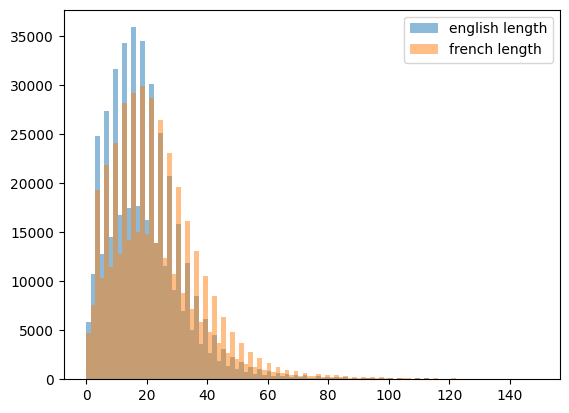

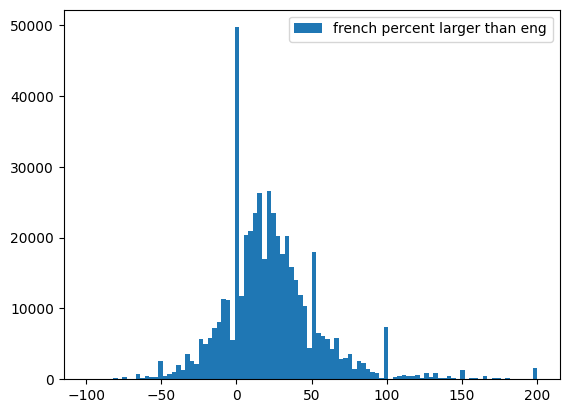

In [ ]:


"""
Plotting how long phrases are in french and english, and how different
corresponding lengths are
"""

import matplotlib.pyplot as plt

#computing sequence lengths
df_subset['en_len'] = df_subset.en.str.split().apply(len)
df_subset['fr_len'] = df_subset.fr.str.split().apply(len)

#plotting histogram of length distribution, filtering out large outliers
plt.hist(df_subset.en_len[df_subset.en_len<150], bins=100, alpha=0.5, label='english length')
plt.hist(df_subset.fr_len[df_subset.fr_len<150], bins=100, alpha=0.5, label='french length')
plt.legend()
plt.show()

#plotting how much longer french is by english, by percentage
fr_per_larger = (df_subset.fr_len-df_subset.en_len)*100/ (df_subset.en_len)
fr_per_larger = fr_per_larger[fr_per_larger<=200]
plt.hist(fr_per_larger, bins=100, label='french percent larger than eng')
plt.legend()
plt.show()

In [ ]:
"""
Printing a random sample, for sanity checking purposes.
"""

#for wrapping text that is too ling
import textwrap

samp = df_subset.sample(1).iloc[0]
samp
print('================== English: {} words ================='.format(samp.en_len))
print(textwrap.fill(samp.en, 100))
print('================== French: {} words ================='.format(samp.fr_len))
print(textwrap.fill(samp.fr, 100))

================== English: 18 words =================
Termination This Implementation Agreement, or parts thereof, may be terminated in writing by any
mutually agreed upon date.
================== French: 24 words =================
Il est entendu que l=exercice des attributions par le comité de gestion en vertu du paragraphe 3.4
des présentes ne constitue pas une modification.


# Creating a text embeder
using a word2vect style word embeder for both english and french.

In this example I'm using pre-trained word-piece embeddings from https://github.com/bheinzerling/bpemb.

In [ ]:
!pip install bpemb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.6 MB/s eta 0:00:00


In [ ]:
"""
subword embeding experimentation

uses BPEmb, which is a subword embeder compatible with multiple languages.
This module loads a pre-trained word embeding, breaks words into sub-words,
places them in an embeding vector, and can convert embeding vectors to sub-words
based on similarity.

Because there's no out-of-the-box support for utility tokens (<start> and <stop>)
I'm planning on using a vector of all zeros to denote non-output. This is important
as I have to pad jagged matrixies when constructing mini-batches, and also decide
when to stop outputting from the model when inferencing.

It's important that this vector can't be confused as a real token, so I'm
experimenting to see if cosin-similarity is used as the similarity function,
which is magnitude invarient. If the embedding is magnitude invarient, I can use
the magnitude of the vector to decide weather to otuput something or not.

An addition to this might be adding another dimension as an "exists or not"
dimension, this could be done both on the input and output.
"""

from bpemb import BPEmb
import numpy as np

#embedding vector length
EMBED_DIM = 50

print('=======================================================')
print('||                      English                      ||')
print('=======================================================')

bpemb_en = BPEmb(lang="en", dim=EMBED_DIM)

txt_en = "How does the janitor misenterperate the signage?"

print('example:')             #printing the example
print(txt_en)
print('\nsub-word tokens:')   #printing the sub-word tokens
print(bpemb_en.encode(txt_en))

for i in range(2):
    print('\n=========== sub-word {} ============='.format(i))
    print('subword "{}":'.format(bpemb_en.encode(txt_en)[i]))
    print('embeding (first 5 dimensions):')
    print(bpemb_en.embed(txt_en)[i][:5])
    print('embeding similarity (top 3):')
    print(bpemb_en.most_similar(bpemb_en.embed(txt_en)[i])[:3])


print('\n\n=======================================================')
print('||                      French                       ||')
print('=======================================================')

bpemb_fr = BPEmb(lang="fr", dim=EMBED_DIM)

txt_fr = "Comment le concierge interprète-t-il mal la signalisation?"

print('example:')             #printing the example
print(txt_fr)
print('\nsub-word tokens:')   #printing the sub-word tokens
print(bpemb_fr.encode(txt_fr))

for i in range(2):
    print('\n=========== sub-word {} ============='.format(i))
    print('subword "{}":'.format(bpemb_fr.encode(txt_fr)[i]))
    print('embeding (first 5 dimensions):')
    print(bpemb_fr.embed(txt_fr)[i][:5])
    print('embeding similarity (top 3):')
    print(bpemb_fr.most_similar(bpemb_fr.embed(txt_fr)[i])[:3])


print('\n\n=======================================================')
print('||                      Utility                       ||')
print('=======================================================')
all1 = np.ones((EMBED_DIM)) * 0.001
print('similarities for magnitude 1')
print(bpemb_fr.most_similar(all1)[:3])
print(bpemb_en.most_similar(all1)[:3])
all1 = np.ones((EMBED_DIM)) * 0.00001
print('similarities for magnitude 2, same direction')
print(bpemb_fr.most_similar(all1)[:3])
print(bpemb_en.most_similar(all1)[:3])
print('\nsimilarities are magnitude invarient')

||                      English                      ||
downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs10000.model


100%|██████████| 400869/400869 [00:00<00:00, 1133908.58B/s]


downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs10000.d50.w2v.bin.tar.gz


100%|██████████| 1924908/1924908 [00:00<00:00, 3171997.10B/s]


example:
How does the janitor misenterperate the signage?

sub-word tokens:
['▁how', '▁does', '▁the', '▁jan', 'itor', '▁mis', 'ent', 'er', 'per', 'ate', '▁the', '▁sign', 'age', '?']

=========== sub-word 0 =============
subword "▁how":
embeding (first 5 dimensions):
[ 0.134556  0.25324  -0.300284 -0.050174  0.225998]
embeding similarity (top 3):
[('▁how', 1.0), ('▁why', 0.8465365767478943), ('▁understand', 0.8464795351028442)]

=========== sub-word 1 =============
subword "▁does":
embeding (first 5 dimensions):
[ 0.371606  0.411344  0.312751 -0.025828  0.197103]
embeding similarity (top 3):
[('▁does', 1.0000001192092896), ('▁makes', 0.7987446784973145), ('▁whether', 0.7980255484580994)]


||                      French                       ||
downloading https://nlp.h-its.org/bpemb/fr/fr.wiki.bpe.vs10000.model


100%|██████████| 400824/400824 [00:00<00:00, 957749.38B/s]


downloading https://nlp.h-its.org/bpemb/fr/fr.wiki.bpe.vs10000.d50.w2v.bin.tar.gz


100%|██████████| 1924882/1924882 [00:00<00:00, 3221262.45B/s]


example:
Comment le concierge interprète-t-il mal la signalisation?

sub-word tokens:
['▁comment', '▁le', '▁con', 'cier', 'ge', '▁interprète', '-', 't', '-', 'il', '▁mal', '▁la', '▁sign', 'alisation', '?']

=========== sub-word 0 =============
subword "▁comment":
embeding (first 5 dimensions):
[-0.242793  0.644877  0.446036 -0.111873 -0.693018]
embeding similarity (top 3):
[('▁comment', 1.0), ('▁lire', 0.7813255190849304), ('▁nous', 0.7470166087150574)]

=========== sub-word 1 =============
subword "▁le":
embeding (first 5 dimensions):
[-0.09845  -0.11444   0.33016   0.275052  0.237902]
embeding similarity (top 3):
[('▁le', 1.0), ('▁premier', 0.8239309787750244), ('▁dernier', 0.8175572156906128)]


||                      Utility                       ||
similarities for magnitude 1
[('▁nuclé', 0.4147549569606781), ('sol', 0.4073708951473236), ('nik', 0.40434518456459045)]
[('▁pam', 0.4569125473499298), ('enda', 0.431844025850296), ('uin', 0.4181838929653168)]
similarities for magnitud

In [ ]:
"""
building a function for embeding an input-output pair,
based on the previous experiments.

Because this will be creating the i/o for the model, this has to accept batches
of english and french pairs.
"""
import torch

#for padding 0s
def boolean_indexing(v):
    lens = np.array([len(item) for item in v])
    print('----')
    print(lens)
    mask = lens[:,None] > np.arange(lens.max())
    mask = np.expand_dims(mask,2)
    mask = np.repeat(mask, EMBED_DIM, 2)
    out = np.zeros((mask.shape[0], mask.shape[1], EMBED_DIM),dtype=int)
    print('----')
    print(out.shape)
    print(mask.shape)
    print(v.shape)
    print(v[0].shape)
    return out

def xy_embeding(batch_en, batch_fr):
    """
    takes in a batch of english sentences, and a corresponding batch of
    french sentences. Embeds each sentence in the batch, then constructs
    a padded tensor containing the embeddings. Outputs a pytorch tensor
    """

    #embedding all sentences
    emb_en = [bpemb_en.embed(txt_en) for txt_en in batch_en]
    emb_fr = [bpemb_en.embed(txt_en) for txt_en in batch_fr]

    #computing the maximum length
    emb_en_maxlen = max([len(e) for e in emb_en])
    emb_fr_maxlen = max([len(e) for e in emb_fr])

    #constructing a placeholder
    emb_en_out = np.zeros((len(emb_en), emb_en_maxlen, EMBED_DIM), dtype=np.float32)
    emb_fr_out = np.zeros((len(emb_en), emb_fr_maxlen, EMBED_DIM), dtype=np.float32)

    #filling in the actual embeddings, both have same batch size
    for i in range(len(batch_en)):
        emb_en_out[i,:emb_en[i].shape[0],:] = emb_en[i]
        emb_fr_out[i,:emb_fr[i].shape[0],:] = emb_fr[i]

    return torch.from_numpy(emb_en_out), torch.from_numpy(emb_fr_out)

#creating a batch of embeddings
#including both language in one to create a jagged array for testing.
#in reality these would be several english and several french examples
#respectively. These are not numpy arrays because they are jagged.
batch_en = ["hello to you", "without a doubt he did?", "expeditiously executed directive is done"]
batch_fr = ["Bonjour à vous", "sans aucun doute il l'a fait?", "directive exécutée rapidement est faite"]

emb_en, emb_fr = xy_embeding(batch_en, batch_fr)
print('test english batched embeddings: {}'.format(emb_en.shape))
print('test french batched embeddings: {}'.format(emb_fr.shape))

test english batched embeddings: torch.Size([3, 9, 50])
test french batched embeddings: torch.Size([3, 15, 50])


# Creating an attention mechanism
Implimenting the attention mechanism from https://arxiv.org/pdf/1409.0473v7.pdf, from scratch.

 - define alignment function with learnable parameters
 - define that function in such a way where it accepts
    - the previous decoder embedding
    - all encoder embeddings
 - Put that into a pytorch module with learnable parameters

In [ ]:
"""
Implimenting the alignment function, which has trainable parameters v, W, and U.
the whole idea is that, given an embedding for the encoder and decoder, the
alignment func outputs a scalar raiting the alignment. So, the shapes of
v, W, and U should be such that the output is a scalar.
"""

import torch
import torch.nn.functional as F

#these need to be sized in such a way that matrix multiplication yields a scalar
#otherwise, they're just general learnable parameters. Different alignment
#functions might have different parameters. For instance, "attention is all you
#need" uses a projection head that generates a query, key, and value, which are
#used in a different self-alignment function. this can allign vectors of different
#lengths
encoder_embedding_dim = EMBED_DIM*2
decoder_embedding_dim = EMBED_DIM

U_attention = torch.rand(EMBED_DIM, encoder_embedding_dim)
W_attention = torch.rand(decoder_embedding_dim, EMBED_DIM)
v_attention = torch.rand(1,EMBED_DIM)

def alignment_func(s, h, W=W_attention, U=U_attention, v=v_attention):
    """
    s: si-1, from the paper, the previous decoder state
    h: hj, from the paper, an input embedding
    W,U,v: trainable parameters

    calculates v*tanh(W*s + U*h), should return the scalar alpha
    """

    v1 = torch.matmul(W,s)
    v2 = torch.matmul(U,h)
    v3 = F.tanh(v1+v2)

    return torch.matmul(v, v3)


In [ ]:
#testing the alignment function between one embedded word and another
#dividing by zero to get them in a good range for tanh
s = torch.rand(decoder_embedding_dim)/50
h = torch.rand(encoder_embedding_dim)/50
alignment_func(s, h)

tensor([16.2514])

In [ ]:
"""
defining attention, wich is a list of softmaxed alignment scores for all input
embeddings (hj) given the previous decoder embedding (si-1). This is equivilent
to a row of the attention matrix, hence the name of the function.
"""

def compute_attention_row(s, hs, W=W_attention, U=U_attention, v=v_attention):
    """
    computes alignments for all h values given s

    s is a vector of length embedding size
    hs is a tensor of shape (sequence length, embedding size)
    the output is a vector of sequence length
    """
    return F.softmax(torch.cat([alignment_func(s, h, W, U, v) for h in hs]),0)

#testing the computation of an allignment row between the previous decoder
#embedding and all encoder embeddings
compute_attention_row(torch.rand(decoder_embedding_dim)/50, torch.rand(10,encoder_embedding_dim)/50)

tensor([0.0541, 0.0790, 0.0875, 0.1084, 0.0649, 0.0490, 0.0944, 0.1974, 0.1529,
        0.1124])

In [ ]:
"""
Defining the attention module

this will go into a larger network later. For now, we will create the module
and train it on a synthetic dataset so we can confirm it can learn simple
alignments.
"""
from torch import nn

class Attention(nn.Module):
    """
    -computes an alignment for all encoder embeddings
    -constructs a context vector using those embeddings
    -outputs that context vector
    """

    def __init__(self, embed_dim=EMBED_DIM, encoder_embedding_dim=encoder_embedding_dim, decoder_embedding_dim=decoder_embedding_dim):
        super(Attention, self).__init__()

        #learnable attention parameters
        self.U = nn.Parameter(torch.rand(embed_dim, encoder_embedding_dim), requires_grad=True )
        self.W = nn.Parameter(torch.rand(embed_dim, decoder_embedding_dim), requires_grad=True )
        self.v = nn.Parameter(torch.rand(1,embed_dim), requires_grad=True )
        self.encoder_embedding_dim = encoder_embedding_dim

        if torch.cuda.is_available():
            self.cuda()

    def forward(self, s, hn):
        """
        computes a batch of context vectors given a current the all encoder
        embeddings and the current decoder embedding
        """
        #defining a tensor consisting of a context vector for each batch
        context = torch.empty((s.shape[0], self.encoder_embedding_dim))

        #iterating over all batches
        for i, (s_single, hn_single) in enumerate(zip(s, hn)):
            weights = compute_attention_row(s_single, hn_single, W=self.W, U=self.U, v=self.v)

            #getting context for this batch
            context_single = torch.sum(hn_single * weights[:, None], axis=0)

            context[i] = context_single

        return context

print('==== Testing Attention ====')
#testing if the attention mechanism can support different sizes
test_attention = Attention()
#getting the context of the first token of every batch. The token embedding
#is of length 50, and and the batch size in this example is 3
# test_attention(emb_fr[:,0], emb_en).shape
test_attention(torch.rand(10,decoder_embedding_dim)/50, torch.rand(10,10,encoder_embedding_dim)/50).shape

==== Testing Attention ====


torch.Size([10, 100])

# Testing attention Mechanism
I want to confirm the attention mechanism can generate reasonable alignments (instead of treating it like a black box and hoping it works). Because there's no positional encoding, and I don't have an encoder and decoder to give me embedded positional information, I have to use the values of `s` and `hn` to create some obvious association.

Here's what I'll do:
the input will have an embedding length of 2. The first number will be the current index, and the next value will be the next inde. I'll shuffle the input, and ask the model to correctly choose the output. So:

The sequence will always start with an unshuffled `[0,1]`, and the model will be given the previous embedding (right or wrong) as `s`. This is to simulate how the decoder will probably have nonsensical output values for `s` initially.

```
[0,1],[5,6],[3,4],[1,2],[2,3] -> [0,1],[1,2],[2,3],[3,4],[5,6]
```


In [ ]:
print(torch.rand(10,decoder_embedding_dim).shape)
print(torch.rand(10,10,encoder_embedding_dim).shape)

torch.Size([10, 50])
torch.Size([10, 10, 100])


 84%|████████▍ | 673/800 [00:20<00:03, 32.90it/s]


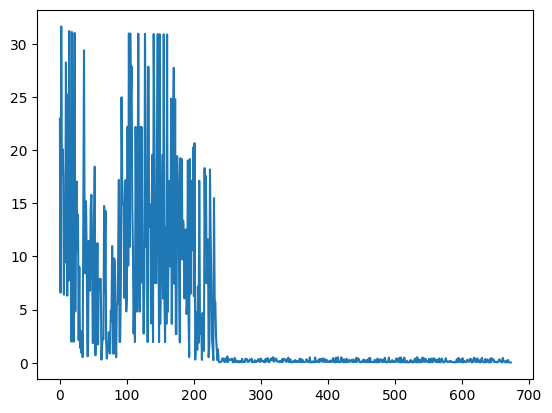

In [ ]:
import random
from tqdm import tqdm
min_len = 5
max_len = 20

test_attention = Attention(10,2,2)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(test_attention.parameters(), lr=1e-2)
lr_phase = 0

#training on some number of random sequences
batch_losses = []
for i in tqdm(range(800)):

    #generating x and y
    y = []
    x = []
    for j in range(random.randint(min_len,max_len)):
        y.append([j, j+1])
        x.append([j,j+1])
    random.shuffle(x)
    x = np.expand_dims(np.array([[0,1]] + x), axis=0).astype(np.float32)
    y = np.expand_dims(np.array([[0,1]] + y), axis=0).astype(np.float32)
    x = torch.from_numpy(x)
    y = torch.from_numpy(y)

    #iterating over all training examples (given s predict s+1)
    s_in = x[:,0]
    sample_losses = []
    for j in range(2,len(x[0])):

        y_this = y[:,j]

        optimizer.zero_grad()
        s_out = test_attention(s_in, x)

        loss = loss_fn(s_out, y_this)
        sample_losses.append(loss.detach())

        # debug printout
        if False:
            print('-------')
            print('in: {}'.format(s_in))
            print('out: {}'.format(s_out))
            print('should be: {}'.format(y_this))
            print('loss: {}'.format(loss))

        loss.backward(retain_graph=True)
        optimizer.step()

        s_in = torch.clone(y_this).detach()

    batch_loss = np.mean(sample_losses)
    batch_losses.append(batch_loss)

    #hacking together a simple learning rate scheduler
    if batch_loss<0.05 and lr_phase == 0:
        optimizer = torch.optim.SGD(test_attention.parameters(), lr=1e-3, momentum=0.2)
        lr_phase+=1

    #stopping training when loss is good enough
    if batch_loss<0.03:
        break

plt.plot(batch_losses)

input: 
[[[ 0.  1.]
  [17. 18.]
  [10. 11.]
  [13. 14.]
  [14. 15.]
  [ 2.  3.]
  [11. 12.]
  [16. 17.]
  [ 5.  6.]
  [18. 19.]
  [ 7.  8.]
  [12. 13.]
  [ 9. 10.]
  [ 3.  4.]
  [ 4.  5.]
  [ 6.  7.]
  [ 8.  9.]
  [15. 16.]
  [ 1.  2.]]]
output: 
[[ 2.  3.]
 [ 3.  4.]
 [ 4.  5.]
 [ 5.  6.]
 [ 6.  7.]
 [ 7.  8.]
 [ 8.  9.]
 [ 9. 10.]
 [10. 11.]
 [11. 12.]
 [12. 13.]
 [13. 14.]
 [14. 15.]
 [15. 16.]
 [16. 17.]
 [17. 18.]
 [18. 19.]]


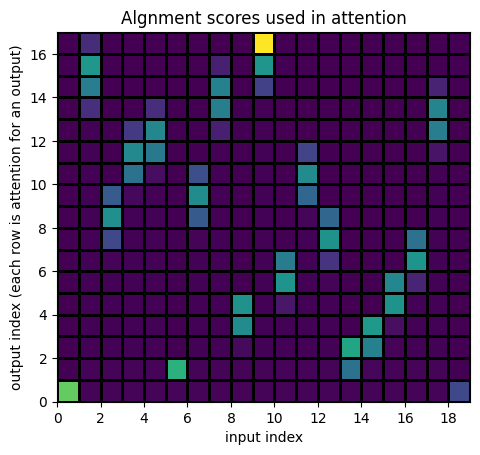

In [ ]:
"""
Visualizing alignment
"""

#generating x and y
y = []
x = []
for j in range(1, random.randint(min_len,max_len)):
    y.append([j, j+1])
    x.append([j,j+1])
random.shuffle(x)

x = np.expand_dims(np.array([[0,1]] + x), axis=0).astype(np.float32)
y = np.expand_dims(np.array([[0,1]] + y), axis=0).astype(np.float32)

x = torch.from_numpy(x)
y = torch.from_numpy(y)



#Extracting learned parameters for generating alignment visual
W = test_attention.W
U = test_attention.U
v = test_attention.v

s = x[:,0]
y_hat = []
rows = []


#predicting the next element in the sequence.
#skipping over the trivia first, and not predicting one after the last.
for _ in range(0,len(x[0])-2):

    #computing attention weights for this output
    row = list(compute_attention_row(s[0], x[0], W=W, U=U, v=v).detach().numpy())
    rows.append(row)

    #predicting what should be in this location.
    with torch.no_grad():
        s = torch.round(test_attention(s, x))

    y_hat.append(list(s[0]))

y_hat = np.array(y_hat)
x_p = np.array(x)

print('input: ')
print(x_p)
print('output: ')
print(y_hat)

from matplotlib.ticker import MaxNLocator
alignments = np.array(rows)

plt.pcolormesh(alignments, edgecolors='k', linewidth=2)
ax = plt.gca()
ax.set_aspect('equal')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('Algnment scores used in attention')
plt.ylabel('output index (each row is attention for an output)')
plt.xlabel('input index')
plt.show()

# Creating The Model
This model uses a bi-directional LSTM as an encoder, a single LSTM as a decoder, and an attention mechanism between.

For simplicity, the embeddings throughtout will have the same dimension. So the hidden state in the encoder, the attention mechanism, the hidden state in the decoder, all consistent. This was defined earlier as `EMBED_DIM`.

The output dimension will have one more output: a boolean telling the model weather to stop outputing or not. I chose to add this chiefly because the embedding I'm using doesn't seem to have convenient support of utility tokens.

In [ ]:
"""
Defining a bi-directional LSTM encoder
"""
import torch.nn as nn
import numpy as np

#defining the bi-directional encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.bilstm = nn.LSTM(input_size=EMBED_DIM,
                              hidden_size=EMBED_DIM,
                              bidirectional=True)

        if torch.cuda.is_available():
            self.cuda()

    def forward(self, x):
        #outputting both layers of the bi-directional lstm as h
        #this will have an embedding size which is twice as long
        #which the attention mechanism needs to account for in the
        #shape of the U matrix
        out, (_, _) = self.bilstm(x)
        return out


print('==== Testing Bi-Directional LSTM encoder ====')
test_encoder = Encoder()
#adding a batch dimension
print('input shape:')
print(emb_en.shape)
print('output shape:')
encoder_output = test_encoder(emb_en)
print(encoder_output.shape)



==== Testing Bi-Directional LSTM encoder ====
input shape:
torch.Size([3, 9, 50])
output shape:
torch.Size([3, 9, 100])


reference of sequence 2 sequence https://www.youtube.com/watch?v=EoGUlvhRYpk
I can probably virtually completely vampire everything but the attention mechanism, which might be easier from a practical perspective.

In [ ]:
"""
Defining an LSTM Decoder
"""

#defining the bi-directional encoder
class Decode(nn.Module):
    def __init__(self, max_len = 100):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_size=EMBED_DIM,
                              hidden_size=EMBED_DIM,
                              bidirectional=False)

        self.max_len = max_len
        if torch.cuda.is_available():
            self.cuda()

    def forward(self, x):

        #Taking in the hidden state modifying, and outputting until end
        for i in range(max_len):
            out, (_, _) = self.lstm(x)
        return out